# Data Exploration

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
seed = 42
np.random.seed(seed)

# importing Data

In [3]:
DATA_FOLDER = 'data/'
TWITTER_FOLDER = DATA_FOLDER + 'twitter-datasets/'
EN_CORE_WEB_SM = DATA_FOLDER + 'en_core_web_sm-3.0.0'

In [4]:
pos = pd.read_csv(TWITTER_FOLDER + 'train_pos_full.txt', sep='\r\t', header=None, names=['tweet'], engine='python')
neg = pd.read_csv(TWITTER_FOLDER + 'train_neg_full.txt', sep='\r\t', header=None, names=['tweet'], engine='python', on_bad_lines='skip')

In [5]:
test_data = pd.read_csv(TWITTER_FOLDER + 'test_data.txt', sep='\t', header=None, names=['tweet'])
test_data['tweet'] = test_data['tweet'].apply(lambda t : t[t.find(',')+1:])

## Defining some useful functions

In [6]:
def combine_pos_neg(pos, neg):
    """
    :param pos: Dataframe containing positive tweets
    :param neg: Dataframe containing negative tweets
    :return: the combination of the two sets with labels in one Dataframe (without duplicates)
    """
    pos['is_pos'] = 1
    neg['is_pos'] = 0
    return pd.concat([pos, neg]).drop_duplicates()

In [7]:
def count_parenthesis(tweet):
    """
    :param tweet: a tweet
    :return: the count of opening parenthesis minus the closing parenthesis
    """
    count = 0
    for c in tweet:
        if c == '(':
            count += 1
        if c == ')':
            count -= 1
    return count


def adding_metadata(tweets):
    """
    Add metadata to the dataframe of tweet : the added metadata are the result of sentiment analysis and the count of parenthesis
    :param tweets: A Dataframe of tweet
    :return: The same dataframe with additional metadata
    """
    analyzer = SentimentIntensityAnalyzer()

    polarity_scores = tweets['tweet'].apply(analyzer.polarity_scores)

    # storing the result of the sentiment analysis
    tweets['neg']       = polarity_scores.apply(lambda d : d['neg'])
    tweets['neu']       = polarity_scores.apply(lambda d : d['neu'])
    tweets['pos']       = polarity_scores.apply(lambda d : d['pos'])
    tweets['compound']  = polarity_scores.apply(lambda d : d['compound'])

    # storing the parenthesis count
    tweets['par_count'] = tweets["tweet"].apply(count_parenthesis)

    # storing tweets length
    tweets['len_tweet'] = tweets["tweet"].apply(lambda t : len(t))
    return tweets

# Adding metadata

In [8]:
tweets = combine_pos_neg(pos, neg)
tweets = adding_metadata(tweets)

# Plots

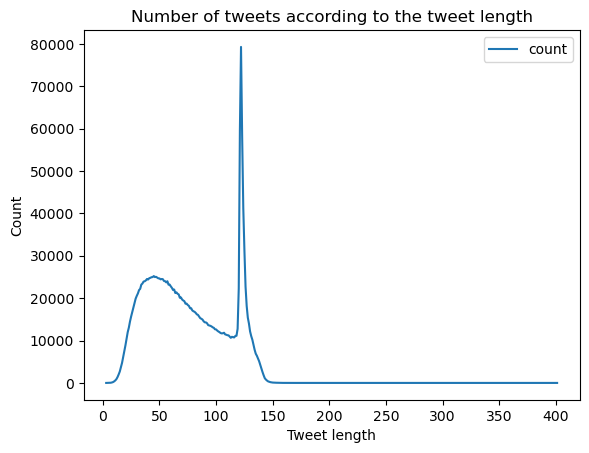

In [9]:
tweet_len_count = tweets[['len_tweet', 'is_pos']].groupby('len_tweet').count().rename(columns = {'is_pos' : 'count'})
tweet_len_count.plot()
plt.xlabel('Tweet length')
plt.ylabel('Count')
plt.title('Number of tweets according to the tweet length');

Above we can se a peak for tweet length of around 120 character

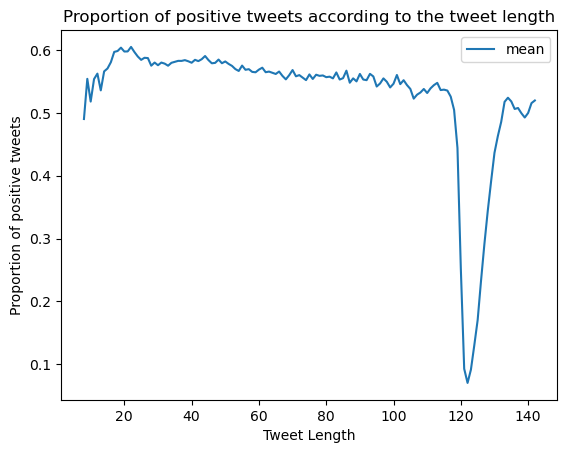

In [10]:
tweet_mean_analysis = tweets[['len_tweet', 'is_pos']].groupby('len_tweet').mean().rename(columns = {'is_pos' : 'mean'})
tweet_mean_analysis[5:140].plot()
plt.xlabel('Tweet Length')
plt.ylabel('Proportion of positive tweets')
plt.title('Proportion of positive tweets according to the tweet length');

Moreover, we remark that tweets of length around 121 has a really unbalanced number of positive/negative tweets

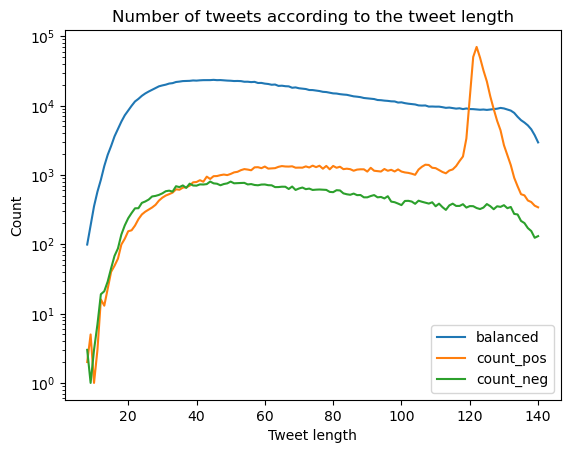

In [11]:
tweets_proportion_by_length              = tweets[tweets.par_count == 0][['len_tweet', 'is_pos']].groupby('len_tweet').count()\
                                           .rename(columns = {'is_pos' : 'balanced'})
tweets_proportion_by_length['count_pos'] = tweets[tweets.par_count > 0][['len_tweet', 'is_pos']].groupby('len_tweet').count()
tweets_proportion_by_length['count_neg'] = tweets[tweets.par_count < 0][['len_tweet', 'is_pos']].groupby('len_tweet').count()
tweets_proportion_by_length[5:138].plot()
plt.semilogy()
plt.xlabel('Tweet length')
plt.ylabel('Count')
plt.title('Number of tweets according to the tweet length');

Further analysis shows us that tweets of lenght around 120 tent to have more open than closed parenthesis

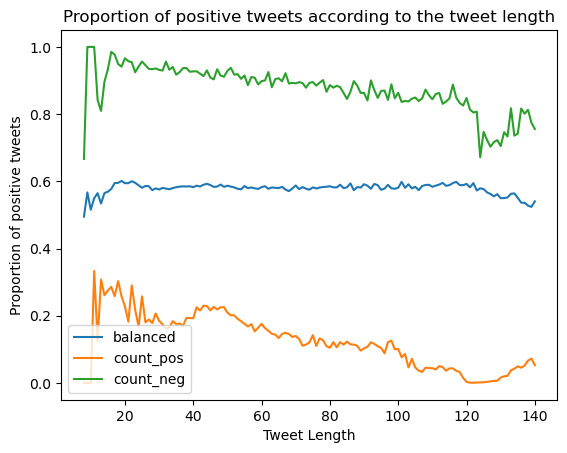

In [12]:
tweets_proportion_by_length              = tweets[tweets.par_count == 0][['len_tweet', 'is_pos']].groupby('len_tweet').mean()\
                                           .rename(columns = {'is_pos' : 'balanced'})
tweets_proportion_by_length['count_pos'] = tweets[tweets.par_count > 0][['len_tweet', 'is_pos']].groupby('len_tweet').mean()
tweets_proportion_by_length['count_neg'] = tweets[tweets.par_count < 0][['len_tweet', 'is_pos']].groupby('len_tweet').mean()
tweets_proportion_by_length[5:138].plot()
plt.xlabel('Tweet Length')
plt.ylabel('Proportion of positive tweets')
plt.title('Proportion of positive tweets according to the tweet length');

Finally, we remark that the tweets with more open parenthesis tend to be more likely to be negative which explains the result seen above

# Other analysis

Proportion of long tweet

In [13]:
long_tweets = tweets[tweets.len_tweet > 140]
len(tweets[tweets.len_tweet > 140])/len(tweets)

0.0035794161768294133

#### Analysis on the parenthesis count

In [14]:
tweets['par_count_pos'] = tweets['par_count'].apply(lambda c : 1 if c>0 else -1 if c<0 else 0)
tweets['is_neutral'] = tweets['compound'].apply(lambda c : 1 if c==0 else 0)
tweets[['par_count_pos', 'is_pos', 'is_neutral']].groupby('par_count_pos').agg(['mean', 'count'])

is_pos          is_neutral         
                   mean    count       mean    count
par_count_pos                                       
-1             0.882440    62904   0.248696    62904
 0             0.581622  1819088   0.246734  1819088
 1             0.036328   388490   0.447438   388490

We can see that the parenthesis balance really influence the positive rate of the tweets.

In [15]:
len(tweets[tweets.par_count == 0]) / len(tweets)

0.8011902318538531

In [16]:
len(tweets[tweets.par_count > 0]) / len(tweets)

0.17110463769367032

In [17]:
len(tweets[tweets.par_count < 0]) / len(tweets)

0.02770513045247661

We have around 80% of the tweets that have balanced number of parenthesis.

Around 17% of the tweets have more open that closed parenthesis.

Around 3% of the tweets have more closed than open parenthesis.

We noticed that if a tweet ends with a parenthesis it is often due to leading parenthesis due to double chin smiley

In [18]:
tweets['end_parenthesis_open'] = tweets['tweet'].apply(lambda t : t[-1] == '(')
tweets['end_parenthesis_closed'] = tweets['tweet'].apply(lambda t : t[-1] == ')')
tweets['end_url'] = tweets['tweet'].apply(lambda t : t[-9:-1] == '... <url')

In [19]:
np.average(tweets[tweets.end_parenthesis_closed]['is_pos'])

0.8729721829785161

In [20]:
np.average(tweets[tweets.end_parenthesis_open]['is_pos'])

0.15083705590113974

We can see that leading parenthesis due to double chin smiley leak some info on the real smiley :
- ':))' is 5 to 6 time more probable than ')):'
- ':((' is 5 to 6 time more probable than '((:'

#### Printing some useful tweets

Below is the longest tweet, we can see that this exceeds 140 char due to the way the dataset is constructed.

In [21]:
tweets[tweets.len_tweet == 401]['tweet'].iloc[0]

'party at your house ? bap bap ! lml rt <user> my birthday is in 10 days ! ! ! \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 211 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 210 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 211 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 210 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 211 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 210 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 211 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 211 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 211'

The tweet used in the report

In [22]:
tweets[tweets['tweet'].apply(lambda t : 'machine learning' in t)]['tweet'].iloc[2]

'machine learning methods for commonsense reasoning processes : interactive models ( premier reference source the ... <url>'

In [23]:
tweets[tweets['tweet'].apply(lambda t : 'looking for some bamboo' in t)]['tweet'].iloc[0]

"looking for some bamboo manlac's photos for his look alike . )"